# For G Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/RL/'

In [1]:
%pip install -U gym[atari,accept-rom-license]==0.21.0

     |████████████████████████████████| 1.5 MB 4.9 MB/s 
     |████████████████████████████████| 1.6 MB 40.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gym: filename=gym-0.21.0-py3-none-any.whl size=1616824 sha256=1a540693fa4dd172c62324fa09f558ac42a21d4e1cc05b1cce563a2cea058b4a
  Stored in directory: /root/.cache/pip/wheels/76/ee/9c/36bfe3e079df99acf5ae57f4e3464ff2771b34447d6d2f2148
  Created wheel for AutoROM.accept-rom-license: filename=AutoROM.accept_rom_license-0.4.2-py3-none-any.whl size=441027 sha256=dfbd2a0b911da740b30176a3d13cc5e80525b4e958578f587a04895b75b57d14
  Stored in directory: /root/.cache/pip/wheels/87/67/2e/6147e7912fe37f5408b80d07527dab807c1d25f5c403a9538a
Successfully built gym AutoROM.accept-rom-license
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [2]:
%pip install tensorflow-gpu

     |████████████████████████████████| 497.5 MB 24 kB/s 
     |████████████████████████████████| 462 kB 54.0 MB/s 


# Main

In [3]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
from IPython import display
from collections import deque
import warnings
import pickle
warnings.filterwarnings("ignore")

In [4]:
env = gym.make('Breakout-v0')

## Simulation

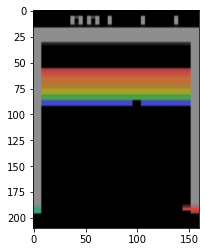

In [ ]:
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
score = 0
done = False
i = 0
while i < 1000 and not done:
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    obs, x, done, _ = env.step(action)
    score += x
    i += 1

## Random Data Generation

In [ ]:
def image_compressor(img, new_size=(75, 80)):

    img_reduced = img[30:195, 5:155,:]
    img_grey = cv2.cvtColor(img_reduced, cv2.COLOR_BGR2GRAY)
    img_compressed = cv2.resize(img_grey, new_size)

    return img_compressed

In [ ]:
cols = ['Obs'+str(i)+'_'+str(m)+'_'+str(n) for i in range(2) for m in range(80) for n in range(75)]
cols.extend(['action', 'reward'])

In [ ]:
def list_to_pdSeries(keys, values):
    dic = {}
    for i in range(len(keys)):
        dic[keys[i]] = values[i]
    return pd.Series(dic)

In [ ]:
episodes = 10
life_memory = []
i_episode = 0

while i_episode < episodes:
    episodic_memory = []
    done = False
    obss = deque(maxlen=2)
    obs = env.reset()
    obss.append(image_compressor(obs))
    action = env.action_space.sample()
    obs, _, _, _ = env.step(action)
    obss.append(image_compressor(obs))
    
    while not done:
        step_memory = []
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        step_memory.extend(obss[0].flatten())
        step_memory.extend(obss[1].flatten())
        step_memory.extend([action, reward])
        episodic_memory.append(list_to_pdSeries(keys=cols, values=step_memory))
        obss.append(image_compressor(obs))
        
    life_memory.extend(episodic_memory)
    i_episode += 1

memory_df = pd.concat(life_memory, axis=1).T

In [ ]:
memory_df.shape

(2347, 12002)

In [ ]:
memory_df.to_csv('random_data.csv', index=False)

## Training

In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Activation, AveragePooling2D, Conv2D, Conv3D, MaxPooling2D, Input, Add, Flatten, Dense, BatchNormalization
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import cv2

In [ ]:
def conv2d_block(X, filters, kernel_size, strides, training=True, initializer=glorot_uniform):
    X = Conv2D(filters, kernel_size, strides, kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X, training=training)
    X = Activation('relu')(X)
    return X

In [ ]:
def model1(input_shape=(165, 150, 3), classes=4):
    X_input = Input(input_shape)
    X = conv2d_block(X_input, 5, 3, (1,1))
    # X = conv2d_block(X, 4,3,(1,1))
    X = conv2d_block(X, 8,3,(1,1))
    # X = conv2d_block(X, 8,3,(2,2))
    X = conv2d_block(X, 16,5,(3,3))
    X = conv2d_block(X, 16,5,(2,2))
    X = AveragePooling2D(pool_size=(2,2))(X)
    X = Flatten()(X)
    X = Dense(256, activation='relu', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Dense(16, activation='relu', kernel_initializer = glorot_uniform(seed=0))(X)
    Y = Dense(1, activation='relu', kernel_initializer = glorot_uniform(seed=0))(X)

    model = Model(inputs=X_input, outputs=Y)

    return model

In [ ]:
model = model1((80, 75, 3), 4)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 75, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 78, 73, 5)         140       
_________________________________________________________________
batch_normalization (BatchNo (None, 78, 73, 5)         20        
_________________________________________________________________
activation (Activation)      (None, 78, 73, 5)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 76, 71, 8)         368       
_________________________________________________________________
batch_normalization_1 (Batch (None, 76, 71, 8)         32        
_________________________________________________________________
activation_1 (Activation)    (None, 76, 71, 8)         0     

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
data = pd.read_csv('random_data.csv')

In [ ]:
data.shape

(2347, 12002)

In [ ]:
data.head()

,Obs0_0_0,Obs0_0_1,Obs0_0_2,Obs0_0_3,Obs0_0_4,Obs0_0_5,Obs0_0_6,Obs0_0_7,Obs0_0_8,Obs0_0_9,...,Obs1_79_67,Obs1_79_68,Obs1_79_69,Obs1_79_70,Obs1_79_71,Obs1_79_72,Obs1_79_73,Obs1_79_74,action,reward
0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,43.0,87.0,2.0,0.0
1,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,43.0,87.0,0.0,0.0
2,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,43.0,87.0,0.0,0.0
3,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,43.0,87.0,3.0,0.0
4,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,142.0,...,0.0,0.0,0.0,0.0,0.0,0.0,43.0,87.0,0.0,0.0


In [ ]:
Y = data['reward'].to_numpy()
actions = data['action'].to_numpy()
X = data.drop(columns=['reward', 'action']).to_numpy()

In [ ]:
def merge_S_A(S, A):
    A_arr = np.ones((S.shape[0], S.shape[1]//2))
    A_bar = A_arr*np.expand_dims((A + 1)*64 - 1, axis=1)
    return np.hstack((S, A_bar))

In [ ]:
X = merge_S_A(X, actions)

In [ ]:
X_train = np.reshape(X, newshape=((2347, 80, 75, 3)))

In [ ]:
X_train.shape

(2347, 80, 75, 3)

In [ ]:
Y_train = Y

In [ ]:
model.fit(X_train, Y_train, epochs=8, batch_size=64)

Epoch 1/8
37/37 [==============================] - 4s 56ms/step - loss: nan - accuracy: 0.9957
Epoch 2/8
37/37 [==============================] - 2s 55ms/step - loss: nan - accuracy: 0.9957
Epoch 3/8
37/37 [==============================] - 2s 55ms/step - loss: nan - accuracy: 0.9957
Epoch 4/8
37/37 [==============================] - 2s 56ms/step - loss: nan - accuracy: 0.9957
Epoch 5/8
37/37 [==============================] - 2s 56ms/step - loss: nan - accuracy: 0.9957
Epoch 6/8
37/37 [==============================] - 2s 57ms/step - loss: nan - accuracy: 0.9957
Epoch 7/8
37/37 [==============================] - 2s 57ms/step - loss: nan - accuracy: 0.9957
Epoch 8/8
37/37 [==============================] - 2s 55ms/step - loss: nan - accuracy: 0.9957


In [ ]:
model.save('model1')

INFO:tensorflow:Assets written to: model1\assets


## Testing and Data Generation

In [ ]:
def model_input(prev, curr, k):
    S = np.reshape(np.array([[prev, curr]] * k), newshape=(k, np.product(prev.shape)*2))
    A = np.array([i for i in range(k)])
    X =  merge_S_A(S, A)
    return np.reshape(X, newshape=((k, 80, 75, 3)))

In [ ]:
obss

In [ ]:
model_input(obss[0], obss[1], 4).shape

(4, 80, 75, 3)

In [ ]:
def image_compressor(img, new_size=(75, 80)):

    img_reduced = img[30:195, 5:155,:]
    img_grey = cv2.cvtColor(img_reduced, cv2.COLOR_BGR2GRAY)
    img_compressed = cv2.resize(img_grey, new_size)

    return img_compressed

In [ ]:
cols = ['Obs'+str(i)+'_'+str(m)+'_'+str(n) for i in range(2) for m in range(80) for n in range(75)]
cols.extend(['action', 'reward'])

In [ ]:
def list_to_pdSeries(keys, values):
    dic = {}
    for i in range(len(keys)):
        dic[keys[i]] = values[i]
    return pd.Series(dic)

In [ ]:
episodes = 100
life_memory = []
i_episode = 0
epsilon = 0

while i_episode < episodes:
    episodic_memory = []
    done = False
    obss = deque(maxlen=2)
    obs = env.reset()
    
    for i in range(10):
        obss.append(image_compressor(obs))
        action = env.action_space.sample()
        obs, _, _, _ = env.step(action)
        obss.append(image_compressor(obs))
    
    while not done:
        step_memory = []
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(model.predict(model_input(obss[0], obss[1], 4)))
        obs, reward, done, info = env.step(action)
        step_memory.extend(obss[0].flatten())
        step_memory.extend(obss[1].flatten())
        step_memory.extend([action, reward])
        episodic_memory.append(list_to_pdSeries(keys=cols, values=step_memory))
        obss.append(image_compressor(obs))
        
    life_memory.extend(episodic_memory)
    i_episode += 1

memory_df = pd.concat(life_memory, axis=1).T

In [ ]:
# memory_df = pd.concat(life_memory, axis=1).T
memory_df.shape

(326, 12002)

In [ ]:
memory_df.to_csv('data_processed.csv', index=False)